# Data analysis

Experiment information:
- One million function evaluations
- **sade_remc**: is the best method from HM, but with more evals
- **sade_mc_final**: is sade + MC + ffi9 + rmsd crowding + spicker + hooke jeeves on cluster centroids
- **sade_remc_final**: is the same as above, but REMC instead of MC
- **sade_mc_ffi9_02**: is HM method + forced fragment insertion of size 2 with 0.02 chance of happening per individal per generation
- **sade_remc_ffi9_02**: same as above but with REMC instead of MC

In [1]:
import datetime
import string
import random
import pickle
import time
import sys
import os
import re

import data_utils

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
sns.set(style="whitegrid");

In [2]:
root_path = '/home/h3nnn4n/progs/de_supimpa/tools/notebooks/analysis'
base_path = '/home/h3nnn4n/progs/de_supimpa/src'


def reset_path():
    os.chdir(base_path)
    
def reset_to_root_path():
    os.chdir(root_path)

    
reset_to_root_path()
reset_path()

In [3]:
runs = [
    'de_experiment_final',
    'de_sade_remc',
    'de_rosetta',
    'de_ffi',
    'de_experiment_final_8_prot',
    'de_final_1rop_1wqc_1lwy',
    'de_rosetta_all_prots',
    'de_other_experiments_all_prots',
    'de_missing_4_base_prots_runs',
    'de_mc_de-mc_de-remc_4prot',
]

In [4]:
protein_blacklist = ['1ab1', '1dfn', '2P5K', '2pmr', '3V1A']

dataset = data_utils.load_all_data(runs)
alldata = data_utils.merge_data(dataset, protein_blacklist=protein_blacklist)


def filter_methods(data, allowed=[]):
    proteins = sorted(list(data.keys()))
    
    for protein in proteins:
        methods = sorted(list(data[protein].keys()))
        
        for method in methods:
            if method not in allowed:
                data[protein].pop(method)
#                 print('[INFO] Deleting %s' % method)
        
    return data


def rename_methods(data, renamer={}):
    proteins = sorted(list(data.keys()))

    for protein in proteins:
        methods = sorted(list(data[protein].keys()))
        
        for method in methods:
            if method in renamer.keys():
                tmp = data[protein].pop(method)
                data[protein][renamer[method]] = tmp


filter_methods(alldata, allowed=['classic-abinitio', 'sade_remc_final', 'sade_mc_final', 'sade_remc'])
rename_methods(alldata, renamer={'sade_remc_final': 'ppf-remc', 'sade_mc_final': 'ppf-mc', 'sade_remc': 'sade-remc'})
print('Finished')

INFO: Loaded 10 experiment runs dataset
removed 5 proteins. Blacklist had 5
Finished


# Boxplot

In [5]:
def summary_to_dataframe(summary, columns=['raw']):
    proteins = sorted(list(summary.keys()))
    methods = sorted(list(summary[proteins[0]].keys()))
    base_columns = ['protein', 'experiment']
    
    d = {}
    for column in columns + base_columns:
        d[column] = []
        
    for protein in proteins:
        for method in methods:
            for raw in summary[protein][method]['data']['raw']:
                d['raw'].append(raw)

                d['protein'].append(protein)
                d['experiment'].append(method)
                                
    return pd.DataFrame(data=d)

In [6]:
def boxplot(mode='best_by_rmsd', metric='rmsd_before', trim_above=None):
    summary = data_utils.experiment_summary(alldata, mode=mode, metric=metric, with_raw=True)
    df = summary_to_dataframe(summary, columns=['raw'])
    
    if trim_above is not None:
        df = df[df.raw < trim_above]
        
    sns.set(rc={'figure.figsize':(16, 10)})
    
    plot = sns.boxplot(x='protein', y='raw', hue='experiment', data=df, width=0.5)
    
    if 'rmsd' in metric:
        what = 'RMSD'
    elif 'score' in metric:
        what = 'Energy'
    
    plot.set_title('%s boxplot' % (what), fontsize=40)
    plot.set_ylabel('%s (Lower is better)' % what, fontsize=20)
    plot.set_xlabel('Protein', fontsize=20)
    plot.tick_params(labelsize=25)

    plt.setp(plot.get_legend().get_texts(), fontsize='22')
    plt.setp(plot.get_legend().get_title(), fontsize='32')

    plot.get_legend().set_title('Methods')

    extension = 'pdf'
    name = '%s_%s_%s.%s' % (
        'boxplot',
        mode,
        metric,
        extension
    )
    
    plot.get_figure().savefig(name, bbox_inches='tight')
    print('Saving %s' % name)

    return plot

Saving boxplot_best_by_energy_scorefxn.pdf


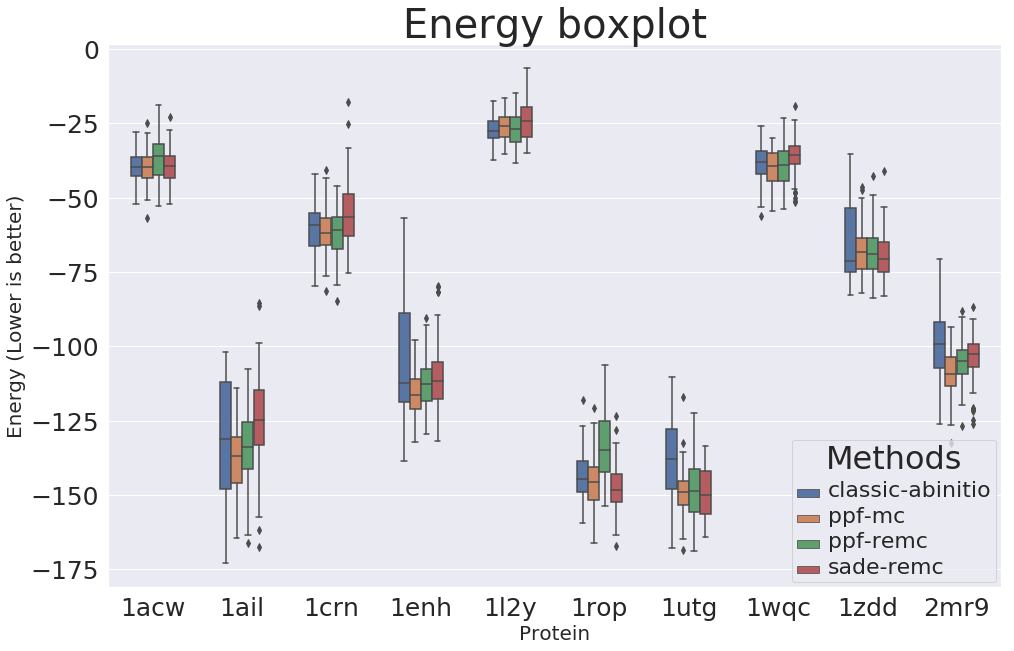

In [7]:
boxplot(mode='best_by_energy', metric='scorefxn')

Saving boxplot_best_by_rmsd_rmsd_after.pdf


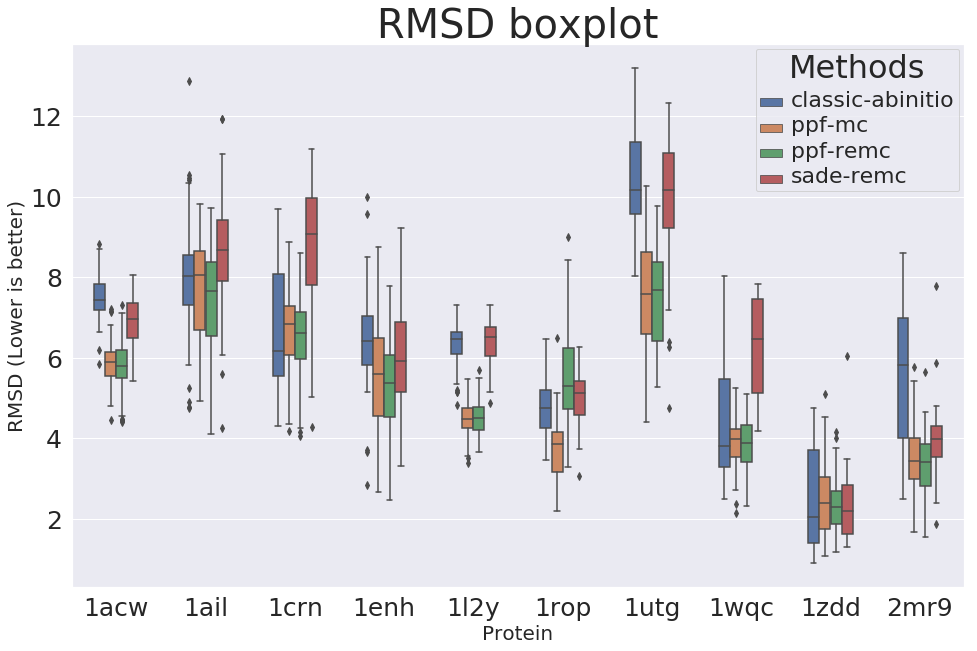

In [8]:
boxplot(mode='best_by_rmsd', metric='rmsd_after')

In [9]:
modes = ['best_by_rmsd', 'best_by_energy']
metrics = ['scorefxn', 'score', 'rmsd_after', 'rmsd_before']

for mode in modes:
    for metric in metrics:
        boxplot(mode=mode, metric=metric).clear();

plt.clf()

Saving boxplot_best_by_rmsd_scorefxn.pdf
Saving boxplot_best_by_rmsd_score.pdf
Saving boxplot_best_by_rmsd_rmsd_after.pdf
Saving boxplot_best_by_rmsd_rmsd_before.pdf
Saving boxplot_best_by_energy_scorefxn.pdf
Saving boxplot_best_by_energy_score.pdf
Saving boxplot_best_by_energy_rmsd_after.pdf
Saving boxplot_best_by_energy_rmsd_before.pdf
